# Module 2 Final Project Specifications


### The Project

For this project, you'll be working with the Northwind database--a free, open-source dataset created by Microsoft containing data from a fictional company. You probably remember the Northwind database from our section on Advanced SQL. Here's the schema for the Northwind database:

<img src='Northwind_ERD.png'>

The goal of this project is to test your ability to gather information from a real-world database and use your knowledge of statistical analysis and hypothesis testing to generate analytical insights that can be of value to the company. 

## The Deliverables

The goal of your project is to query the database to get the data needed to perform a statistical analysis.  In this statistical analysis, you'll need to perform a hypothesis test (or perhaps several) to answer the following question:

**_Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?_**

In addition to answering this question with a hypothesis test, you will also need to come up with **_at least 3 other hypotheses to test on your own_**.  These can by anything that you think could be imporant information for the company. 

For this hypothesis, be sure to specify both the **_null hypothesis_** and the **_alternative hypothesis_** for your question.  You should also specify if this is one-tail or a two-tail test. 



In [204]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
from sqlalchemy import MetaData
from sqlalchemy.ext.automap import automap_base
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib inline

from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import category_encoders as ce
from statsmodels.stats.power import TTestIndPower, FTestPower, FTestAnovaPower

In [2]:
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for col in cols_list:
        print("Name: {} \t Type: {}".format(col['name'], col['type']))

In [3]:
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=False)
Session = sessionmaker(bind=engine)
session = Session()
inspector = inspect(engine)
con = engine.connect()
metadata = MetaData()

In [4]:
# Get names of tables in database
inspector.get_table_names()


['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

In [5]:
get_columns_info('Employee')

Table Name: Employee

Name: Id 	 Type: INTEGER
Name: LastName 	 Type: VARCHAR(8000)
Name: FirstName 	 Type: VARCHAR(8000)
Name: Title 	 Type: VARCHAR(8000)
Name: TitleOfCourtesy 	 Type: VARCHAR(8000)
Name: BirthDate 	 Type: VARCHAR(8000)
Name: HireDate 	 Type: VARCHAR(8000)
Name: Address 	 Type: VARCHAR(8000)
Name: City 	 Type: VARCHAR(8000)
Name: Region 	 Type: VARCHAR(8000)
Name: PostalCode 	 Type: VARCHAR(8000)
Name: Country 	 Type: VARCHAR(8000)
Name: HomePhone 	 Type: VARCHAR(8000)
Name: Extension 	 Type: VARCHAR(8000)
Name: Photo 	 Type: BLOB
Name: Notes 	 Type: VARCHAR(8000)
Name: ReportsTo 	 Type: INTEGER
Name: PhotoPath 	 Type: VARCHAR(8000)


In [6]:
rs = con.execute("SELECT * FROM Shipper")
rs.fetchall()

[(1, 'Speedy Express', '(503) 555-9831'),
 (2, 'United Package', '(503) 555-3199'),
 (3, 'Federal Shipping', '(503) 555-9931')]

In [7]:
order = pd.read_sql_query("SELECT * FROM [Order]", engine)
order.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [8]:
#rs = con.execute("SELECT * FROM Category")
order_detail = pd.read_sql_query("SELECT * FROM Orderdetail", engine)
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [9]:
customers = pd.read_sql_query("SELECT * FROM Customer", engine)
customers.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


In [10]:
#rs = con.execute("SELECT * FROM Category")
employee = pd.read_sql_query("SELECT * FROM Employee", engine)

#employee['SalePrice'] = employee.UnitPrice * employee.Quantity

employee

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp
5,6,Suyama,Michael,Sales Representative,Mr.,1995-07-02,2025-10-17,Coventry House Miner Rd.,London,British Isles,EC2 7JR,UK,(71) 555-7773,428,None,Michael is a graduate of Sussex University (MA...,5.0,http://accweb/emmployees/davolio.bmp
6,7,King,Robert,Sales Representative,Mr.,1992-05-29,2026-01-02,Edgeham Hollow Winchester Way,London,British Isles,RG1 9SP,UK,(71) 555-5598,465,None,Robert King served in the Peace Corps and trav...,5.0,http://accweb/emmployees/davolio.bmp
7,8,Callahan,Laura,Inside Sales Coordinator,Ms.,1990-01-09,2026-03-05,4726 - 11th Ave. N.E.,Seattle,North America,98105,USA,(206) 555-1189,2344,None,Laura received a BA in psychology from the Uni...,2.0,http://accweb/emmployees/davolio.bmp
8,9,Dodsworth,Anne,Sales Representative,Ms.,1998-01-27,2026-11-15,7 Houndstooth Rd.,London,British Isles,WG2 7LT,UK,(71) 555-4444,452,None,Anne has a BA degree in English from St. Lawre...,5.0,http://accweb/emmployees/davolio.bmp


In [11]:
employee.SalePrice.corr(employee.Quantity)

AttributeError: 'DataFrame' object has no attribute 'SalePrice'

In [ ]:
products = pd.read_sql_query("SELECT * FROM Product", engine)
products.head()

In [12]:
metadata = MetaData()

metadata.reflect(engine)

Base = automap_base(metadata=metadata)

Base.prepare()

Employee, Customer = Base.classes.Employee, Base.classes.Customer

In [13]:
Product, Category = Base.classes.Product, Base.classes.Category

In [14]:
products = []
for p, c in session.query(Product, Category).filter(Product.CategoryId==Category.Id).all():
    print('Product Name: {} Category Name: {}'.format(p.ProductName, c.CategoryName))

Product Name: Chai Category Name: Beverages
Product Name: Chang Category Name: Beverages
Product Name: Aniseed Syrup Category Name: Condiments
Product Name: Chef Anton's Cajun Seasoning Category Name: Condiments
Product Name: Chef Anton's Gumbo Mix Category Name: Condiments
Product Name: Grandma's Boysenberry Spread Category Name: Condiments
Product Name: Uncle Bob's Organic Dried Pears Category Name: Produce
Product Name: Northwoods Cranberry Sauce Category Name: Condiments
Product Name: Mishi Kobe Niku Category Name: Meat/Poultry
Product Name: Ikura Category Name: Seafood
Product Name: Queso Cabrales Category Name: Dairy Products
Product Name: Queso Manchego La Pastora Category Name: Dairy Products
Product Name: Konbu Category Name: Seafood
Product Name: Tofu Category Name: Produce
Product Name: Genen Shouyu Category Name: Condiments
Product Name: Pavlova Category Name: Confections
Product Name: Alice Mutton Category Name: Meat/Poultry
Product Name: Carnarvon Tigers Category Name: Se

C:\Users\Danyal\Anaconda3\envs\learn-env\lib\site-packages\sqlalchemy\sql\sqltypes.py:603: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  'storage.' % (dialect.name, dialect.driver))


## Understanding the impact of discounts

- Assess discount for:
    * Discount vs Employee
    * Dicount vs Product
    * Discount vs Region
    * Discount vs Customer
    
- Take into consideration:
    * Hypotheses, FDR, power, beta, alpha
    * Interactions
    * Assumptions ANOVA (is using regression more robust?)
    * Effect sizes and estimated cost impacts

### Exploring Discount

In [15]:
# Get names of tables in database
inspector.get_table_names()

['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

In [117]:
# Create Table with all relevant information for discount and product analysis
product = pd.read_sql_query("""SELECT p.*, od.Quantity, od.Discount, od.UnitPrice as OrderUnitPrice
                       FROM Product p
                       left join OrderDetail od
                       on p.ID = od.ProductID
                       """, engine)

In [118]:
# no missing data
product.isna().sum()

Id                 0
ProductName        0
SupplierId         0
CategoryId         0
QuantityPerUnit    0
UnitPrice          0
UnitsInStock       0
UnitsOnOrder       0
ReorderLevel       0
Discontinued       0
Quantity           0
Discount           0
OrderUnitPrice     0
dtype: int64

In [119]:
product.drop(['Id'], axis=1, inplace=True)

In [126]:
product.Profit.sum()

3728.5099999999998

In [127]:
product['Profit'] =  product.UnitPrice - product.OrderUnitPrice

In [128]:
product.Profit.describe()

count    2155.000000
mean        1.730167
std         4.431286
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        52.700000
Name: Profit, dtype: float64

In [129]:
category = pd.read_sql_table('Category', engine)
category.head()

category.rename(columns={'Id': 'CategoryId'}, inplace=True)
category.head()

,CategoryId,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"


In [130]:
product = pd.merge(product, category, on='CategoryId')

In [131]:
product.head()

,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Quantity,Discount,OrderUnitPrice,Profit,CategoryName,Description
0,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10,0.00,14.4,3.6,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,12,0.00,14.4,3.6,Beverages,"Soft drinks, coffees, teas, beers, and ales"
2,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,15,0.00,14.4,3.6,Beverages,"Soft drinks, coffees, teas, beers, and ales"
3,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,15,0.15,14.4,3.6,Beverages,"Soft drinks, coffees, teas, beers, and ales"
4,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,15,0.15,14.4,3.6,Beverages,"Soft drinks, coffees, teas, beers, and ales"


In [132]:
product.Discount.sort_values().unique()

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1 , 0.15, 0.2 , 0.25])

In [133]:
product.groupby('CategoryName')['Discount'].describe().round(3)

,count,mean,std,min,25%,50%,75%,max
CategoryName,,,,,,,,
Beverages,404.0,0.062,0.088,0.0,0.0,0.0,0.15,0.25
Condiments,216.0,0.053,0.078,0.0,0.0,0.0,0.10,0.25
Confections,334.0,0.057,0.083,0.0,0.0,0.0,0.10,0.25
Dairy Products,366.0,0.053,0.081,0.0,0.0,0.0,0.10,0.25
Grains/Cereals,196.0,0.045,0.078,0.0,0.0,0.0,0.05,0.25
Meat/Poultry,173.0,0.064,0.089,0.0,0.0,0.0,0.10,0.25
Produce,136.0,0.045,0.077,0.0,0.0,0.0,0.05,0.25
Seafood,330.0,0.060,0.086,0.0,0.0,0.0,0.10,0.25


In [134]:
product.loc[product['Discount'] == 0.0, 'DiscountBinary'] = 0
product.loc[product['Discount'] > 0.0, 'DiscountBinary'] = 1

In [180]:
product.loc[product['Discount'] == 0.0, 'DiscountGrouped'] = '0'
product.loc[(product['Discount'] > 0.0) & (product['Discount'] <= 0.05), 'DiscountGrouped'] = '1'
product.loc[(product['Discount'] > 0.05) & (product['Discount'] <= 0.10), 'DiscountGrouped'] = '2'
product.loc[(product['Discount'] > 0.10) & (product['Discount'] <= 0.15), 'DiscountGrouped'] = '3'
product.loc[(product['Discount'] > 0.15) & (product['Discount'] <= 0.20), 'DiscountGrouped'] = '4'
product.loc[(product['Discount'] > 0.20) & (product['Discount'] <= 0.25), 'DiscountGrouped'] = '5'

In [181]:
product['ExtendedPrice'] = product.OrderUnitPrice * product.Quantity * (1 - product.Discount)

In [182]:
product['PriceChange'] = product.OrderUnitPrice - product.UnitPrice

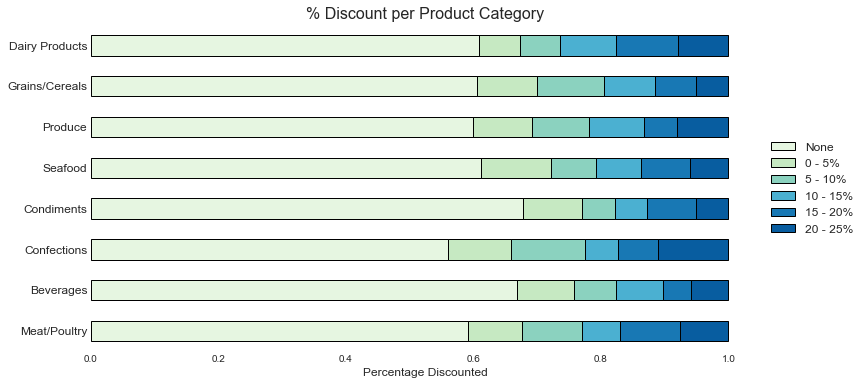

In [211]:
plt.style.use('seaborn-white')

discount = product.groupby('CategoryName')['DiscountGrouped'].value_counts(normalize=True).unstack('DiscountGrouped')

discount.plot(kind='barh', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
              figsize=(12,6), edgecolor = "black")

plt.gca().invert_yaxis()
plt.ylabel('')
plt.yticks(np.arange(8), (['Dairy Products', 'Grains/Cereals', 'Produce', 'Seafood',
       'Condiments', 'Confections', 'Beverages', 'Meat/Poultry']), fontsize=12)
plt.xlabel('Percentage Discounted', fontsize=12)
plt.legend(('None', '0 - 5%', '5 - 10%', '10 - 15%', '15 - 20%', '20 - 25%'), fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('% Discount per Product Category', fontsize=16);
sns.despine(left=True, bottom=True)

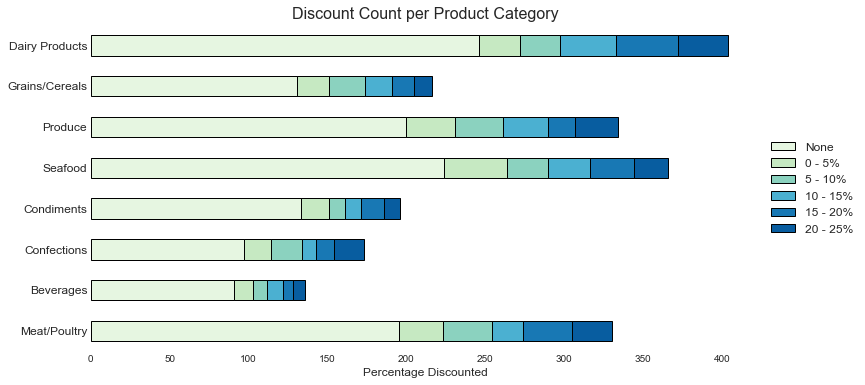

In [184]:
def boxplot(data, x, y): #xlabel, ylabel, title):
    meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
    fig, axes = plt.subplots(1, figsize=(9,6))
    sns.boxplot(x=x, y=y, data=data, ax=axes, palette=("husl"), boxprops=dict(alpha=.8), 
                showmeans=True, meanprops=meanpointprops)
    sns.swarmplot(x=x, y=y, data=data, color="grey", alpha=0.6)
    plt.xticks(fontsize=10)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14);

In [185]:
product.groupby(['DiscountGrouped'])['Quantity'].describe()

,count,mean,std,min,25%,50%,75%,max
DiscountGrouped,,,,,,,,
0,1317.0,21.715262,17.507493,1.0,10.0,18.0,30.00,130.0
1,192.0,27.052083,22.331332,1.0,12.0,20.0,35.25,120.0
2,174.0,25.103448,21.198503,2.0,10.0,20.0,30.00,130.0
3,157.0,28.382166,20.923099,2.0,15.0,21.0,40.00,100.0
4,161.0,27.024845,18.832801,2.0,12.0,21.0,40.00,100.0
5,154.0,28.240260,20.120570,2.0,15.0,25.0,36.00,120.0


In [186]:
product.groupby(['DiscountGrouped'])['OrderPrice'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
DiscountGrouped,,,,,,,,
0,1317.0,606.96,1009.23,6.00,150.00,357.5,700.00,15810.0
1,192.0,856.43,1533.78,23.25,205.34,426.0,915.00,15810.0
2,174.0,640.90,704.16,12.00,181.00,397.5,789.25,3952.5
3,157.0,702.65,743.85,10.00,241.25,450.0,892.50,3944.0
4,161.0,767.93,1503.98,18.00,192.00,397.5,875.00,13175.0
5,154.0,909.75,1420.79,24.00,240.00,482.5,999.38,10540.0


In [141]:
product.groupby(['DiscountBinary'])['Quantity'].mean()

DiscountBinary
0.0    21.715262
1.0    27.109785
Name: Quantity, dtype: float64

In [142]:
product.groupby(['DiscountBinary'])['OrderPrice'].mean()

DiscountBinary
0.0    606.957054
1.0    775.662136
Name: OrderPrice, dtype: float64

In [143]:
product.DiscountBinary = product.DiscountBinary.astype(int)
cat_df = pd.DataFrame()

cat_df['OrderPrice'] = product.OrderPrice
cat_df['Quantity'] = product.Quantity
cat_df['DiscountBinary'] = product.DiscountBinary.astype('category')
cat_df['DiscountGrouped'] = product.DiscountGrouped.astype('category')

In [144]:
# Create dummy variables
cat_df = pd.get_dummies(cat_df);
cat_df.head()


,OrderPrice,Quantity,DiscountBinary_0,DiscountBinary_1,DiscountGrouped_0,DiscountGrouped_1,DiscountGrouped_2,DiscountGrouped_3
0,180.0,10,1,0,1,0,0,0
1,216.0,12,1,0,1,0,0,0
2,270.0,15,1,0,1,0,0,0
3,270.0,15,0,1,0,0,1,0
4,270.0,15,0,1,0,0,1,0


In [145]:
#cat_df.rename(columns={'CategoryName_Dairy Products': 'CategoryName_Dairy_Products', 'CategoryName_Meat/Poultry':\
#                      'CategoryName_Meat_Poultry', 'CategoryName_Grains/Cereals': 'CategoryName_Grains_Cereals'}, inplace=True)
cat_df.columns

Index(['OrderPrice', 'Quantity', 'DiscountBinary_0', 'DiscountBinary_1',
       'DiscountGrouped_0', 'DiscountGrouped_1', 'DiscountGrouped_2',
       'DiscountGrouped_3'],
      dtype='object')

In [146]:
# Model each set of dummy variables separately to check how much variance each set is accouting for
cols_binary_dis = cat_df.columns[2:4]
cols_group_dis = cat_df.columns[4:8]
 

cols = [cols_binary_dis, cols_group_dis]
for col in cols:
    sum_cols = "+".join(col)
    form = "Quantity ~" + sum_cols
    model = smf.ols(formula= form, data= cat_df).fit()
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     41.97
Date:                Mon, 10 Dec 2018   Prob (F-statistic):           1.14e-10
Time:                        16:58:39   Log-Likelihood:                -9384.3
No. Observations:                2155   AIC:                         1.877e+04
Df Residuals:                    2153   BIC:                         1.878e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           16.2750      0.278  

In [147]:
formula = 'Quantity ~ DiscountBinary'
lm = ols(formula, product).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table.round())

                  sum_sq      df     F  PR(>F)
DiscountBinary   14904.0     1.0  42.0     0.0
Residual        764496.0  2153.0   NaN     NaN


In [148]:
lm = smf.ols('Quantity ~ DiscountBinary', data = product).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     41.97
Date:                Mon, 10 Dec 2018   Prob (F-statistic):           1.14e-10
Time:                        16:58:40   Log-Likelihood:                -9384.3
No. Observations:                2155   AIC:                         1.877e+04
Df Residuals:                    2153   BIC:                         1.878e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         21.7153      0.519     41.

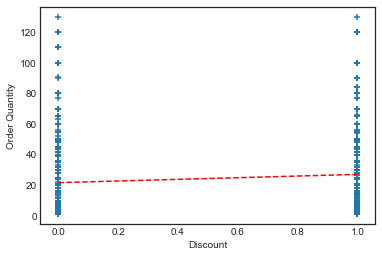

In [149]:
plt.scatter(product.DiscountBinary, product.Quantity, marker = "+")
plt.plot([0, 1], [np.mean(product.query('DiscountBinary == 0').Quantity), np.mean(product.query('DiscountBinary == 1').Quantity)], 'r--')
plt.ylabel("Order Quantity")
plt.xlabel("Discount")
plt.show()

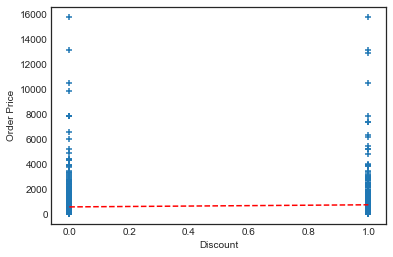

In [150]:
plt.scatter(product.DiscountBinary, product.OrderPrice, marker = "+")
plt.plot([0, 1], [np.mean(product.query('DiscountBinary == 0').OrderPrice), np.mean(product.query('DiscountBinary == 1').OrderPrice)], 'r--')
plt.ylabel("Order Price")
plt.xlabel("Discount")
plt.show()

In [175]:
lm = smf.ols('ExtendedPrice ~ Quantity', data = product).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:          ExtendedPrice   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     644.2
Date:                Mon, 10 Dec 2018   Prob (F-statistic):          1.52e-124
Time:                        18:43:17   Log-Likelihood:                -17594.
No. Observations:                2155   AIC:                         3.519e+04
Df Residuals:                    2153   BIC:                         3.520e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1090     29.360      0.174      0.8

In [152]:
lm = smf.ols('Quantity ~ OrderPrice', data = product).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     664.6
Date:                Mon, 10 Dec 2018   Prob (F-statistic):          6.02e-128
Time:                        16:58:41   Log-Likelihood:                -9115.2
No. Observations:                2155   AIC:                         1.823e+04
Df Residuals:                    2153   BIC:                         1.825e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.2167      0.419     43.486      0.0

In [153]:
product.head()

,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Quantity,Discount,OrderUnitPrice,Profit,CategoryName,Description,DiscountBinary,DiscountGrouped,OrderPrice
0,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10,0.00,14.4,3.6,Beverages,"Soft drinks, coffees, teas, beers, and ales",0,0,180.0
1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,12,0.00,14.4,3.6,Beverages,"Soft drinks, coffees, teas, beers, and ales",0,0,216.0
2,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,15,0.00,14.4,3.6,Beverages,"Soft drinks, coffees, teas, beers, and ales",0,0,270.0
3,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,15,0.15,14.4,3.6,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,2,270.0
4,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,15,0.15,14.4,3.6,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,2,270.0


In [189]:
from patsy.contrasts import Treatment

levels = [1,2,3,4,5,6]

contrast = Treatment(reference=0).code_without_intercept(levels)

print(contrast.matrix)

[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [190]:
lm = smf.ols('Quantity ~ C(DiscountGrouped, contrast)', data = product).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     9.041
Date:                Mon, 10 Dec 2018   Prob (F-statistic):           1.62e-08
Time:                        18:57:25   Log-Likelihood:                -9382.6
No. Observations:                2155   AIC:                         1.878e+04
Df Residuals:                    2149   BIC:                         1.881e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [166]:
len(product.CategoryId.unique())

8

In [171]:
from patsy.contrasts import Sum

levels = [i for i in range(8)]

sum_contrast = Sum().code_without_intercept(levels)

print(sum_contrast.matrix)

[[ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.]
 [-1. -1. -1. -1. -1. -1. -1.]]


In [176]:
lm = smf.ols('ExtendedPrice ~ C(CategoryId, sum_contrast)', data = product).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:          ExtendedPrice   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     7.198
Date:                Mon, 10 Dec 2018   Prob (F-statistic):           1.54e-08
Time:                        18:43:31   Log-Likelihood:                -17851.
No. Observations:                2155   AIC:                         3.572e+04
Df Residuals:                    2147   BIC:                         3.576e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [159]:
from patsy.contrasts import Helmert

helmert = Helmert().code_without_intercept(levels)

print(helmert.matrix)

[[-1. -1. -1.]
 [ 1. -1. -1.]
 [ 0.  2. -1.]
 [ 0.  0.  3.]]


In [116]:
lm = smf.ols('Quantity ~ C(DiscountGrouped, contrast)', data = product).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     14.61
Date:                Mon, 10 Dec 2018   Prob (F-statistic):           2.03e-09
Time:                        16:25:57   Log-Likelihood:                -9383.3
No. Observations:                2155   AIC:                         1.877e+04
Df Residuals:                    2151   BIC:                         1.880e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [205]:
effect_size = 0.4
alpha = 0.05 # significance level
power = 0.8

power_analysis = FTestAnovaPower()
sample_size = power_analysis.solve_power(effect_size = effect_size, 
                                         power = power, 
                                         alpha = alpha)

print('Required sample size: {0:.2f}'.format(sample_size))

Required sample size: 51.05


In [210]:
smp.FTestPower().solve_power(effect_size=0.1, df_num=2147, df_denom=7, alpha=0.05)

0.9462437132531423

In [ ]:
# GLM 
from patsy import dmatrices

formula = """Quantity ~ C(DiscountGrouped, dummy_contrast)"""
response, predictors = dmatrices(formula, product, return_type='dataframe')
po_results = sm.GLM(response, predictors, family=sm.families.Poisson()).fit()
print(po_results.summary())

In [ ]:
# rlm
from statsmodels.formula.api import rlm

rlm_model = rlm("Quantity ~ C(DiscountGrouped, dummy_contrast)", data=product, 
                      M=sm.robust.norms.TukeyBiweight()).fit(conv="weights")
print(rlm_model.summary())